In [1]:
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
from pymob import Config
from pymob.sim.plot import SimulationPlot
import matplotlib as mpl

from hierarchical_molecular_tktd.sim import (
    NomixHierarchicalSimulation, 
    plot_y0
)

config = Config("../scenarios/hierarchical_cext_nested_sigma_hyperprior_rna_pulse_5/settings.cfg")
config.case_study.package = "../.."
config.case_study.data_path = "../../tktd_rna_pulse/data"
sim = NomixHierarchicalSimulation(config)
sim.setup()
sim.dispatch_constructor()
sim.set_inferer("numpyro")
sim.inferer.load_results("numpyro_svi_posterior.nc")

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/hierarchical_cext_nested_sigma_hyperprior_rna_pulse_5'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested_sigma_hyperprior_rna_pulse_5'.
Jax 64 bit mode: False
Absolute tolerance: 1e-05


In [2]:
experiments = [19, 12, 26, 34, 36, 44, 41, 47]
sim.observations = sim.observations.where(sim.observations.experiment_id.isin(experiments), drop=True)

sim.model_parameters["y0"] = sim.parse_input("y0", reference_data=sim.observations, drop_dims=["time"])

MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)


In [3]:
sim.dispatch_constructor()


In [4]:
e = sim.dispatch()
e()

res = e.results

In [6]:
sim.inferer.idata.posterior_model_fits = sim.inferer.idata.posterior_model_fits.sel(id=sim.observations.id)

KeyError: None

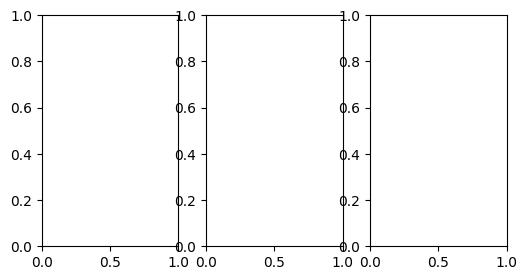

In [10]:
simplot = SimulationPlot(
    observations=sim.observations,
    idata=sim.inferer.idata,
    indices=sim.indices,
    rows=["survival"],
    columns="substance",
    coordinates=sim.dimension_coords,
    sharey=False,
    config=sim.config,
    obs_idata_map={"survival": lambda x: x["survival"] * sim.observations.nzfe},
    idata_groups=["posterior_model_fits"],
)   
simplot.plot_data_variables()

NameError: name 'data_structure' is not defined

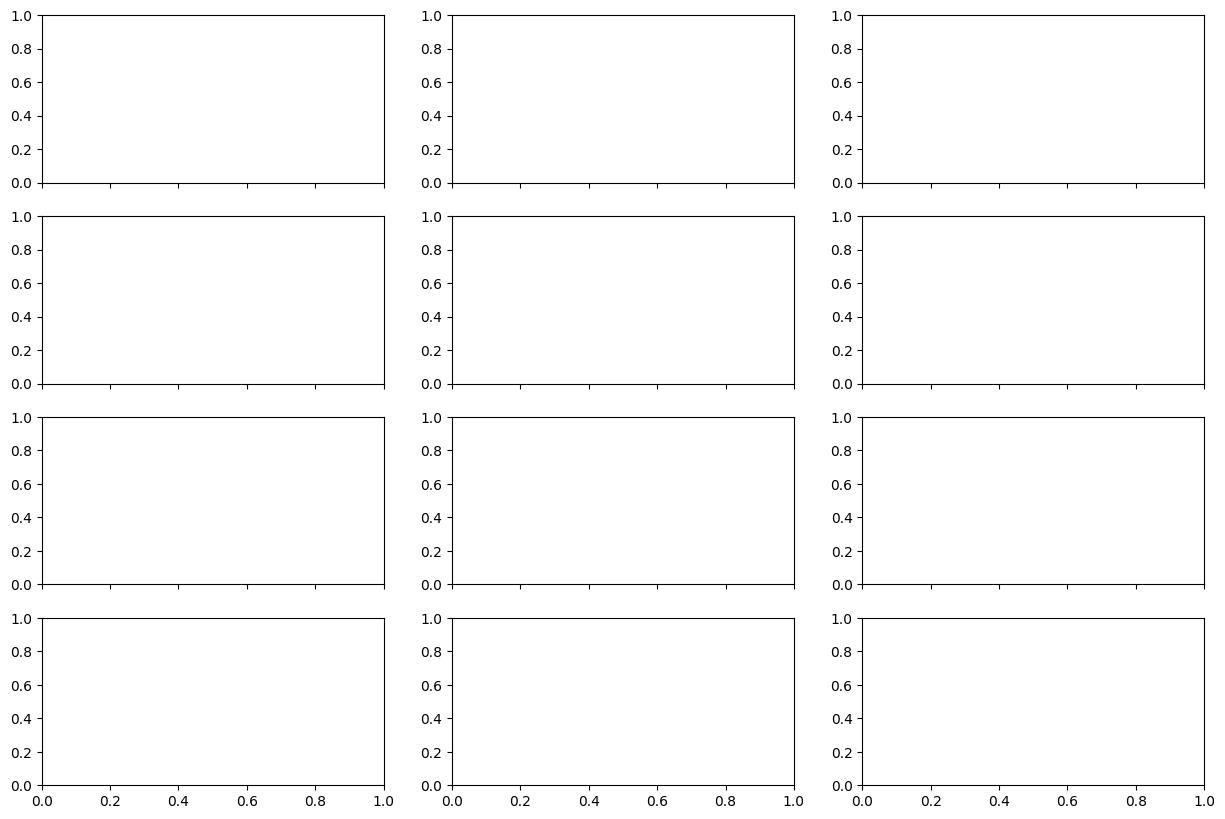

In [11]:
res = res.assign_coords({"substance": sim.observations.substance})
cmap = mpl.colormaps["cool"]

col_dim = "substance"

ncols = sim.dimension_sizes[col_dim]
norws = sim.config.data_structure.all

sim.dimension_sizes
fig, axes = plt.subplots(4, ncols, sharex=True, figsize=(15,10))


SimulationPlot(
    observations=sim.observations,
    idata=sim.inferer.load_results("numpyro_svi_posterior.nc"),
    columns=
)


for r, (v, vdict) in enumerate(data_structure.items()):
    for c, (s, sdict) in enumerate(vdict["substances"].items()):
        sdata = sim.observations.where(sim.observations.substance == s, drop=True)
        C = np.round(sdata.cext_nom.values, 1)
        norm = mpl.colors.Normalize(vmin=C.min(), vmax=C.max())
        for eid in sdict["experiment_ids"]:

            ax, meta, obs_ids, _ = sim._plot.plot_experiment(
                self=sim,
                experiment_id=eid,
                substance=s,
                data_var=v,
                cmap=cmap,
                norm=norm,
                ax=axes[r, c]
            )

            if v != "survival":
                ax.set_xlabel("")

            if v == "P":
                ax.set_ylabel("Protein")
                ax.spines[["right", "top"]].set_visible(False)

            if v == "nrf2":
                ax.set_ylim(0, 4)
                # note that the thresholds are mixed up. Diuron and Diclofenac should swap
                z = sim.inferer.idata.posterior.z.mean(("chain", "draw")).values
                ax.hlines(z[c], -10, 120, color="black", lw=0.5)

            if c != 0:
                ax.set_ylabel("")

            l = ax.get_legend()
            if l is not None:
                l.remove()
            if v == "cext":
                ax.set_title(s.capitalize())
            else:
                ax.set_title("")

            res_ids = sim.get_ids(res, {"substance": s, "experiment_id": eid})

            for i in res_ids:
                y = res.sel(id=i)
                ax.plot(res.time, y[v], color=cmap(norm(y.cext.isel(time=0))))
